# Model interpretation for Visual Question Answering


In this notebook we demonstrate how to apply model interpretability algorithms from captum library on VQA models. More specifically we explain model predictions by applying integrated gradients on a small sample of image-question pairs. More details about Integrated gradients can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

As a reference VQA model we use the following open source implementation:
https://github.com/Cyanogenoid/pytorch-vqa
  
  **Note:** Before running this tutorial, please install the torchvision, PIL, and matplotlib packages.

Note: Before running this tutorial, please, make sure that you have installed `matplotlib`, `PIL` and `torchvision` packages.

In [19]:
import os, sys


# Clone PyTorch VQA project from: https://github.com/Cyanogenoid/pytorch-vqa and add to your filepath
# Replace <PROJECT-DIR> placeholder with your project directory path
sys.path.append(os.path.realpath('/home/narine/pytorch-vqa'))

# Clone PyTorch Resnet model from: https://github.com/Cyanogenoid/pytorch-resnet and add to your filepath
# We can also use standard resnet model from torchvision package, however the model from `pytorch-resnet` 
# is slightly different from the original resnet model and performs better on this particular VQA task
sys.path.append(os.path.realpath('/home/narine/pytorch-resnet'))

In [20]:
import numpy as np
import threading

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import resnet  # from pytorch-resnet

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

from model import Net, apply_attention, tile_2d_over_nd # from pytorch-vqa
from utils import get_transform # from pytorch-vqa

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization, configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


from torch.nn.parallel.scatter_gather import scatter_kwargs, scatter

from captum.attr._utils.gradient import compute_gradients, _extract_device_ids, _forward_layer_distributed_eval, _gather_distributed_tensors


In [21]:
#!/usr/bin/env python3
import torch

from captum.attr._utils.approximation_methods import approximation_parameters
from captum.attr._utils.batching import _batched_operator
from captum.attr._utils.common import (
    _validate_input,
    _format_additional_forward_args,
    _format_attributions,
    _format_input_baseline,
    _reshape_and_sum,
    _expand_additional_forward_args,
    _expand_target,
)

from captum.attr._utils.attribution import LayerAttribution, GradientAttribution
from captum.attr._utils.gradient import _run_forward, _forward_layer_distributed_eval

class LayerIntegratedGradients(LayerAttribution, GradientAttribution):
    def __init__(self, forward_func, layer, device_ids=None):
        r"""
        Args:

            forward_func (callable):  The forward function of the model or any
                          modification of it
        """
        LayerAttribution.__init__(self, forward_func, layer, device_ids=device_ids)
        GradientAttribution.__init__(self, forward_func)
    
    def attribute(
        self,
        inputs,
        baselines=None,
        target=None,
        additional_forward_args=None,
        n_steps=50,
        method="gausslegendre",
        internal_batch_size=None,
        return_convergence_delta=False,
        attribute_to_layer_input=False, # TODO remove this?
    ):
        # Keeps track whether original input is a tuple or not before
        # converting it into a tuple.
        is_inputs_tuple = isinstance(inputs, tuple)

        inputs, baselines = _format_input_baseline(inputs, baselines)
        _validate_input(inputs, baselines, n_steps, method)

        additional_forward_args = _format_additional_forward_args(
            additional_forward_args
        )
        
        expanded_inputs = tuple(torch.cat([input] * n_steps, dim=0) for input in inputs)
        expanded_baselines = tuple(torch.cat([baseline] * n_steps, dim=0) for baseline in baselines)     

        expanded_additional_args = ( \
            _expand_additional_forward_args(additional_forward_args, n_steps)
            if additional_forward_args is not None
            else None
        )
        
        device_ids = None
        if hasattr(self.forward_func, 'device_ids'):
            device_ids = self.forward_func.device_ids

        expanded_target = _expand_target(target, n_steps)

        # retrieve step size and scaling factor for specified approximation method
        step_sizes_func, alphas_func = approximation_parameters(method)
        step_sizes, alphas = step_sizes_func(n_steps), alphas_func(n_steps)

        num_examples = len(inputs[0])
        expanded_alphas = torch.tensor(alphas).repeat_interleave(num_examples)[:, None]

        if device_ids is None:
            scattered_expanded_alphas = (expanded_alphas.to(inputs[0].device), )
        else:
            scattered_expanded_alphas = scatter(expanded_alphas, target_gpus=device_ids)

        scattered_expanded_alphas_dict = {scattered_expanded_alpha.device: scattered_expanded_alpha for scattered_expanded_alpha in scattered_expanded_alphas}

        inputs_layer_dict = _forward_layer_distributed_eval(self.forward_func, expanded_inputs, self.layer,
                            additional_forward_args=expanded_additional_args,
                            attribute_to_layer_input=attribute_to_layer_input)

        for key, input_layer_dict in inputs_layer_dict.items():
            print(input_layer_dict.shape)

        # TODO check that baselines has the same shape and dimensionality as the inputs
        baselines_layer_dict = _forward_layer_distributed_eval(self.forward_func, expanded_baselines, self.layer,
                            additional_forward_args=expanded_additional_args,
                            attribute_to_layer_input=attribute_to_layer_input)

        # scale features and compute gradients. (batch size is abbreviated as bsz)
        # scaled_features' dim -> (bsz * #steps x inputs[0].shape[1:], ...)
        scaled_features_dict = {input_device: 
            baselines_layer_dict[input_device] + (scattered_expanded_alphas_dict[input_device] * (inputs_layer_dict[input_device] - \
            baselines_layer_dict[input_device]).view(inputs_layer_dict[input_device].shape[0], -1)).view(inputs_layer_dict[input_device].shape)
        for input_device in inputs_layer_dict.keys()}

        # apply number of steps to additional forward args
        # currently, number of steps is applied only to additional forward arguments
        # that are nd-tensors. It is assumed that the first dimension is
        # the number of batches.
        # dim -> (bsz * #steps x additional_forward_args[0].shape[1:], ...)

        def layer_forward_hook(module, inputs, outputs):
            outputs = scaled_features_dict[outputs.device] #scaled_features_tpl[0].clone()
            return outputs

        hook = self.layer.register_forward_hook(layer_forward_hook)
        #expand inputs before passing
        print(expanded_target.shape)
        print(expanded_inputs[0].shape)
        output = _run_forward(self.forward_func, expanded_inputs, expanded_target, expanded_additional_args)
        hook.remove() 
        print('scaled_features_dict: ', scaled_features_dict)
        if device_ids is None:
            scattered_ouputs = (output, )
        else:
            scattered_ouputs = scatter(output, target_gpus=device_ids)
        
        # grads: dim -> (bsz * #steps x inputs[0].shape[1:], ...)
        grads_dict = {scattered_ouput.device: self.gradient_func(
            self.forward_func,
            scaled_features_dict[scattered_ouput.device],
            output=scattered_ouput
        )[0] for scattered_ouput in scattered_ouputs}

        device_ids = _extract_device_ids(self.forward_func, grads_dict, self.device_ids)

        print('grads_dict: ', grads_dict)
        grads = _gather_distributed_tensors(grads_dict, device_ids=device_ids)
        grads = (grads, )
        # flattening grads so that we can multilpy it with step-size
        # calling contiguous to avoid `memory whole` problems
        scaled_grads = [
            grad.contiguous().view(n_steps, -1)
            * torch.tensor(step_sizes).view(n_steps, 1).to(grad.device)
            for grad in grads
        ]

        # aggregates across all steps for each tensor in the input tuple
        # total_grads has the same dimensionality as inputs
        total_grads = [
            _reshape_and_sum(
                scaled_grad, n_steps, grad.shape[0] // n_steps, grad.shape[1:]
            )
            for (scaled_grad, grad) in zip(scaled_grads, grads)
        ]

        inputs_layer = _gather_distributed_tensors(inputs_layer_dict, device_ids=device_ids)
        inputs_layer = (inputs_layer, )
        baselines_layer = _gather_distributed_tensors(baselines_layer_dict, device_ids=device_ids)
        baselines_layer = (baselines_layer, )

        # computes attribution for each tensor in input tuple
        # attributions has the same dimensionality as inputs
        attributions = tuple(
            total_grad * (input[:num_examples] - baseline[:num_examples])
            for total_grad, input, baseline in zip(total_grads, inputs_layer, baselines_layer)
        )
        if return_convergence_delta:
            start_point, end_point = baselines, inputs
            # computes approximation error based on the completeness axiom
            delta = self.compute_convergence_delta(
                attributions,
                start_point,
                end_point,
                additional_forward_args=additional_forward_args,
                target=target,
            )
            return _format_attributions(is_inputs_tuple, attributions), delta
        return _format_attributions(is_inputs_tuple, attributions)

    def has_convergence_delta(self):
        return True

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading VQA model

VQA model can be downloaded from: 
https://github.com/Cyanogenoid/pytorch-vqa/releases/download/v1.0/2017-08-04_00.55.19.pth

In [23]:
saved_state = torch.load('models/2017-08-04_00.55.19.pth', map_location=device)

# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w


Loads predefined VQA model and sets it to eval mode.
`device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`

In [24]:
vqa_net = torch.nn.DataParallel(Net(num_tokens))
vqa_net.load_state_dict(saved_state['weights'])
vqa_net.to(device)
vqa_net.eval()

DataParallel(
  (module): Net(
    (text): TextProcessor(
      (embedding): Embedding(15193, 300, padding_idx=0)
      (drop): Dropout(p=0.5, inplace=False)
      (tanh): Tanh()
      (lstm): LSTM(300, 1024)
    )
    (attention): Attention(
      (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (q_lin): Linear(in_features=1024, out_features=512, bias=True)
      (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
      (drop): Dropout(p=0.5, inplace=False)
      (relu): ReLU(inplace=True)
    )
    (classifier): Classifier(
      (drop1): Dropout(p=0.5, inplace=False)
      (lin1): Linear(in_features=5120, out_features=1024, bias=True)
      (relu): ReLU()
      (drop2): Dropout(p=0.5, inplace=False)
      (lin2): Linear(in_features=1024, out_features=3000, bias=True)
    )
  )
)

Converting string question into a tensor. `encode_question` function is similar to original implementation of `encode_question` method in pytorch-vqa source code.
https://github.com/Cyanogenoid/pytorch-vqa/blob/master/data.py#L110



In [25]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)


# Defining end-to-end VQA model

Original saved model does not have image network's (resnet's) layers attached to it. We attach it in the below cell using forward-hook. The rest of the model is identical to the original definition of the model: https://github.com/Cyanogenoid/pytorch-vqa/blob/master/model.py#L48

In [26]:
class EarlyForwardTerminationException(Exception):
    def __init__(self, message=''):
        self.message = message

class ResNetLayer4(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.r_model = resnet.resnet152(pretrained=True)
        self.r_model.eval()
        self.r_model.to(device)

        self.buffer = {}
        lock = threading.Lock()

        def save_output(module, input, output):
            with lock:
                self.buffer[output.device]= output
            raise EarlyForwardTerminationException('Terminating ResNetLayer4 early after accessing the 4th layer')
                
        self.r_model.layer4.register_forward_hook(save_output)

    def forward(self, x):
        try:
            self.r_model(x)
        except EarlyForwardTerminationException as eftex:
            # Commenting out the logging to make output less verbose
            # print('EarlyForwardTerminationException: ', eftex.message)
            pass
        return self.buffer[x.device]

class VQA_Resnet_Model(Net):
    def __init__(self, embedding_tokens):
        super().__init__(embedding_tokens)
        self.resnet_layer4 = ResNetLayer4()
        
    def forward(self, v, q, q_len):
        q = self.text(q, list(q_len.data))
        print(q)
        v = self.resnet_layer4(v)
        v = v / (v.norm(p=2, dim=1, keepdim=True).expand_as(v) + 1e-8)

        a = self.attention(v, q)
        v = apply_attention(v, a)

        combined = torch.cat([v, q], dim=1)
        answer = self.classifier(combined)
        return answer


Updating weights from the saved model and removing the old model from the memory.

In [27]:
vqa_resnet = VQA_Resnet_Model(vqa_net.module.text.embedding.num_embeddings)
# `device_ids` contains a list of GPU ids which are used for paralelization supported by `DataParallel`
vqa_resnet = torch.nn.DataParallel(vqa_resnet)

# saved vqa model's parameters
partial_dict = vqa_net.state_dict()

state = vqa_resnet.state_dict()
state.update(partial_dict)
vqa_resnet.load_state_dict(state)

vqa_resnet.to(device)
vqa_resnet.eval()

# This is original VQA model without resnet. Removing it, since we do not need it
del vqa_net


Below function will help us to transform and image into a tensor.

In [28]:
image_size = 448  # scale image to given size and center
central_fraction = 1.0

transform = get_transform(image_size, central_fraction=central_fraction)
    
def image_to_features(img):
    img_transformed = transform(img)
    img_batch = img_transformed.unsqueeze(0).to(device)
    return img_batch


In order to explain text features, we introduce interpretable embedding layers which allows access word embeddings and generate meaningful attributions for each embedding dimension.

configure_interpretable_embedding_layer function separates embedding layer from the model and precomputes word embeddings in advance. The embedding layer of our model is then being replaced by an Interpretable Embedding Layer which wraps original embedding layer and takes word embedding vectors as inputs of the forward function. This allows to generate baselines for word embeddings and compute attributions for each embedding dimension.

Note: After finishing interpretation it is important to call remove_interpretable_embedding_layer which removes the Interpretable Embedding Layer that we added for interpretation purposes and sets the original embedding layer back in the model.

In [29]:
#interpretable_embedding = configure_interpretable_embedding_layer(vqa_resnet, 'module.text.embedding')

Creating reference aka baseline / background for questions. This is specifically necessary for baseline-based model interpretability algorithms. In this case for integrated gradients. More details can be found in the original paper: https://arxiv.org/pdf/1703.01365.pdf

In [30]:
PAD_IND = token_to_index['pad']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND)

In [31]:
# this is necessary for the backpropagation of RNNs models in eval mode
torch.backends.cudnn.enabled=False

Creating an instance of integrated gradients. It will be used to intepret model's predictions.

In [32]:
ig = LayerIntegratedGradients(vqa_resnet, vqa_resnet.module.text.embedding)

Defining default cmap that will be used for image visualizations 

In [33]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#252b36'),
                                                  (1, '#000000')], N=256)


Defining a few test images for model intepretation purposes

In [34]:
images = ['./img/vqa/siamese.jpg',
          './img/vqa/elephant.jpg',
          './img/vqa/zebra.jpg']

In [35]:
def vqa_resnet_interpret(image_filename, questions, targets):
    img = Image.open(image_filename).convert('RGB')
    original_image = transforms.Compose([transforms.Scale(int(image_size / central_fraction)),
                                   transforms.CenterCrop(image_size), transforms.ToTensor()])(img) 
    
    image_features = image_to_features(img).requires_grad_().to(device)
    for question, target in zip(questions, targets):
        q, q_len = encode_question(question)

        #q_input_embedding = interpretable_embedding.indices_to_embeddings(q).unsqueeze(0)
        q = q.unsqueeze(0)
        print(q.shape)
        print(q_len.unsqueeze(0))
        print(image_features.shape)
        # Making prediction. The output of prediction will be visualized later
        ans = vqa_resnet(image_features, q, q_len.unsqueeze(0))
        print('ans.shape: ', ans.shape)
        pred, answer_idx = F.softmax(ans, dim=1).data.cpu().max(dim=1)
        
        # generate reference for each sample
        q_reference_indices = token_reference.generate_reference(q_len.item(), 
                                                                 device=device).unsqueeze(0)
        print('answer_idx: ', answer_idx)
        #q_reference = interpretable_embedding.indices_to_embeddings(q_reference_indices).to(device)
        attributions = ig.attribute(inputs=(image_features, q),
                                    baselines=(image_features * 0.0, q_reference_indices),
                                    target=answer_idx,
                                    additional_forward_args=q_len.unsqueeze(0),
                                    n_steps=30)
        attributions = (attributions[0], attributions[0])
        # Visualize text attributions
        text_attributions_norm = attributions[1].sum(dim=2).squeeze(0).norm()
        vis_data_records = [visualization.VisualizationDataRecord(
                                attributions[1].sum(dim=2).squeeze(0) / text_attributions_norm,
                                pred[0].item(),
                                answer_words[ answer_idx ],
                                answer_words[ answer_idx ],
                                target,
                                attributions[1].sum(),       
                                question.split(),
                                0.0)]
        visualization.visualize_text(vis_data_records)

        # visualize image attributions
        original_im_mat = np.transpose(original_image.cpu().detach().numpy(), (1, 2, 0))
        attr = np.transpose(attributions[0].squeeze(0).cpu().detach().numpy(), (1, 2, 0))
        
        visualization.visualize_image_attr_multiple(attr, original_im_mat, 
                                                    ["original_image", "heat_map"], ["all", "absolute_value"], 
                                                    titles=["Original Image", "Attribution Magnitude"],
                                                    cmap=default_cmap,
                                                    show_colorbar=True)
        print('Text Contributions: ', attributions[1].sum().item())
        print('Image Contributions: ', attributions[0].sum().item())
        print('Total Contribution: ', attributions[0].sum().item() + attributions[1].sum().item())


In [36]:
# the index of image in the test set. Please, change it if you want to play with different test images/samples.
image_idx = 1 # elephant
vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color is the elephant",
    "where is the elephant"
], ['elephant', 'gray', 'zoo'])

torch.Size([1, 5])
tensor([5], device='cuda:0')
torch.Size([1, 3, 448, 448])
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
ans.shape:  torch.Size([1, 3000])
answer_idx:  tensor([46])
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:7', grad_fn=<SqueezeBackward1>)
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:3', grad_fn=<SqueezeBackward1>)
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
    

grads_dict:  {device(type='cuda', index=0): tensor([[[ 0.1165, -0.6839, -0.3121,  ...,  0.3358,  0.1180,  0.3928],
         [-0.0566, -0.2757, -0.2275,  ...,  0.1798,  0.7168,  0.0891],
         [ 0.4666, -0.2760, -0.6875,  ..., -1.2669, -0.0036, -0.5498],
         [ 0.1522,  0.2721, -0.6948,  ...,  0.4322,  0.2781, -0.4781],
         [ 0.5218,  0.0425, -0.6203,  ...,  0.6584, -0.6129, -0.3945]],

        [[ 0.1337, -0.6410, -0.2931,  ...,  0.3256,  0.1236,  0.4008],
         [-0.0682, -0.2775, -0.2285,  ...,  0.1810,  0.7074,  0.0849],
         [ 0.4565, -0.2685, -0.6881,  ..., -1.2413, -0.0046, -0.5489],
         [ 0.1494,  0.2774, -0.7063,  ...,  0.4393,  0.2744, -0.4802],
         [ 0.5084,  0.0445, -0.6254,  ...,  0.6520, -0.6075, -0.3891]],

        [[ 0.1446, -0.6020, -0.2805,  ...,  0.3428,  0.1797,  0.3817],
         [-0.0794, -0.2861, -0.2360,  ...,  0.1910,  0.7166,  0.0729],
         [ 0.4490, -0.2542, -0.6874,  ..., -1.1775,  0.0173, -0.5515],
         [ 0.1636,  0.2901, -

Target Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
elephant,elephant (0.55),elephant,10.00,what is on the picture


ValueError: axes don't match array

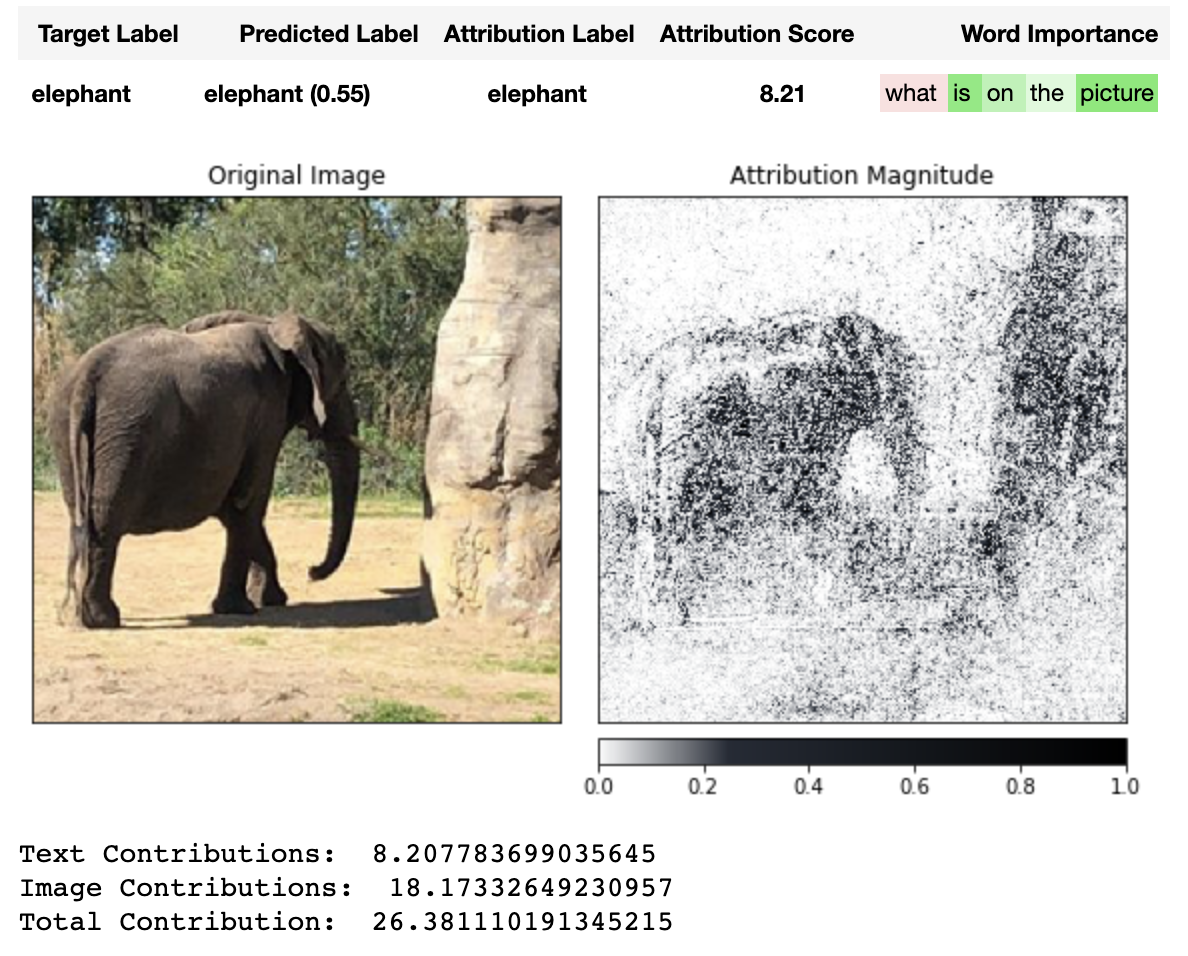

In [38]:
import IPython
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/elephant_attribution.jpg')

In [39]:
image_idx = 0 # cat

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the cat's eyes",
    "is the animal in the picture a cat or a fox",
    "what color is the cat",
    "how many ears does the cat have",
    "where is the cat"
], ['cat', 'blue', 'cat', 'white and brown', '2', 'at the wall'])

torch.Size([1, 5])
tensor([5], device='cuda:0')
torch.Size([1, 3, 448, 448])
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
ans.shape:  torch.Size([1, 3000])
answer_idx:  tensor([30])
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:7', grad_fn=<SqueezeBackward1>)
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037]],
       device='cuda:6', grad_fn=<SqueezeBackward1>)
tensor([[-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
        [-0.0081, -0.0401,  0.0046,  ..., -0.0358, -0.0036, -0.0037],
    

target.shape:  torch.Size([1])
output.shape:  torch.Size([30, 3000])
scaled_features_dict:  {device(type='cuda', index=0): tensor([[[-0.2446, -0.1280,  0.1311,  ..., -0.1095, -0.2494,  0.1221],
         [-0.2447, -0.1279,  0.1311,  ..., -0.1095, -0.2496,  0.1224],
         [-0.2446, -0.1280,  0.1312,  ..., -0.1094, -0.2495,  0.1224],
         [-0.2446, -0.1278,  0.1311,  ..., -0.1095, -0.2496,  0.1222],
         [-0.2445, -0.1281,  0.1310,  ..., -0.1096, -0.2495,  0.1222]],

        [[-0.2429, -0.1275,  0.1303,  ..., -0.1084, -0.2470,  0.1209],
         [-0.2436, -0.1275,  0.1301,  ..., -0.1085, -0.2479,  0.1223],
         [-0.2428, -0.1278,  0.1308,  ..., -0.1083, -0.2475,  0.1225],
         [-0.2429, -0.1270,  0.1300,  ..., -0.1085, -0.2478,  0.1216],
         [-0.2427, -0.1281,  0.1296,  ..., -0.1091, -0.2473,  0.1214]],

        [[-0.2399, -0.1268,  0.1289,  ..., -0.1067, -0.2427,  0.1188],
         [-0.2416, -0.1267,  0.1283,  ..., -0.1069, -0.2448,  0.1222],
         [-0.2395, -0

Target Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
cat,cat (0.88),cat,7.53,what is on the picture


ValueError: axes don't match array

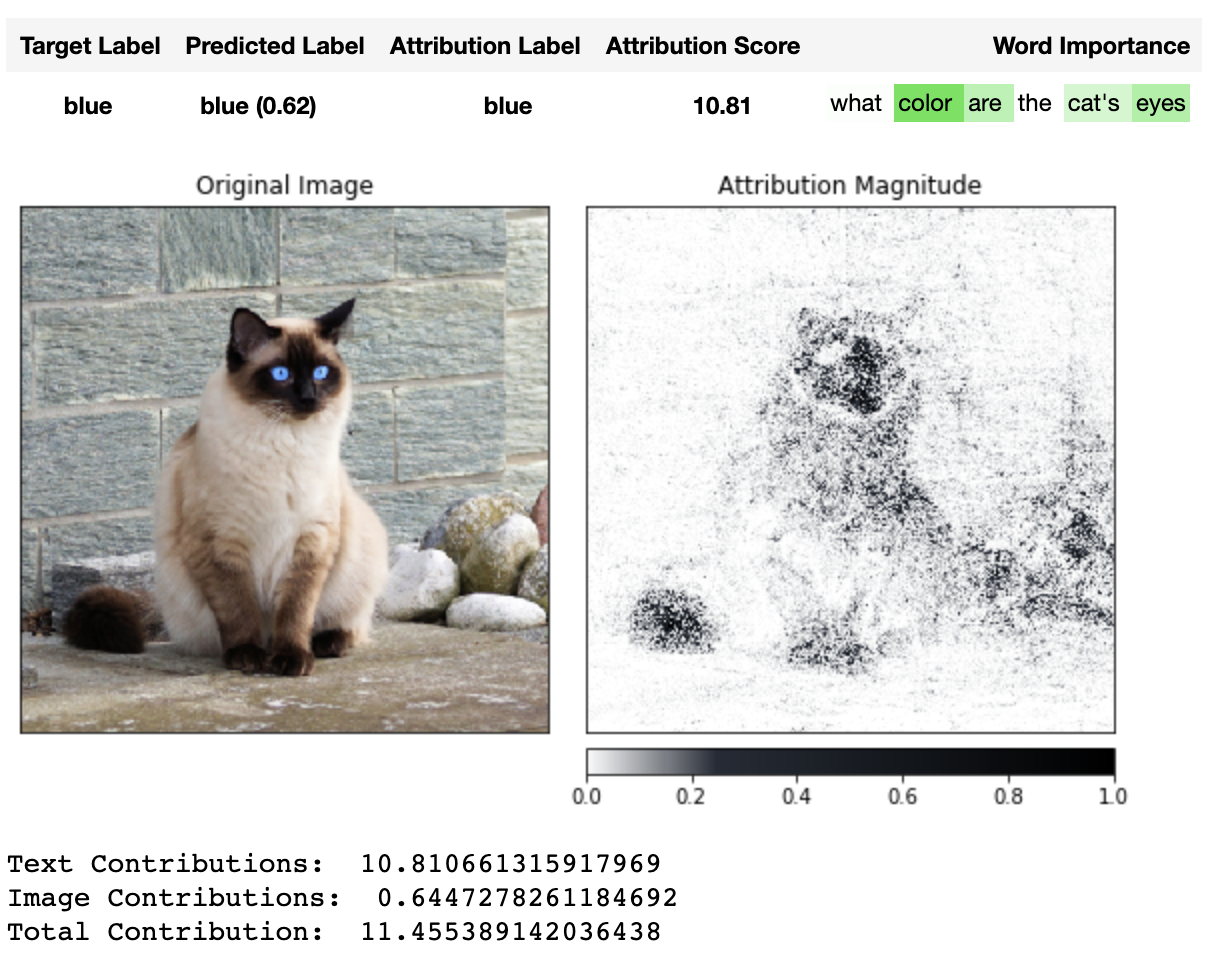

In [40]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/siamese_attribution.jpg')

In [ ]:
image_idx = 2 # zebra

vqa_resnet_interpret(images[image_idx], [
    "what is on the picture",
    "what color are the zebras",
    "how many zebras are on the picture",
    "where are the zebras"
], ['zebra', 'black and white', '2', 'zoo'])


In [ ]:
# Above cell generates an output similar to this:
IPython.display.Image(filename='img/vqa/zebra_attribution.jpg')

As mentioned above, after we are done with interpretation, we have to remove Interpretable Embedding Layer and set the original embeddings layer back to the model.

In [ ]:
remove_interpretable_embedding_layer(vqa_resnet, interpretable_embedding)

In [ ]:
vqa_resnet